# Project 2 - Part 1

In [94]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Exploratory Data Analysis

In [123]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

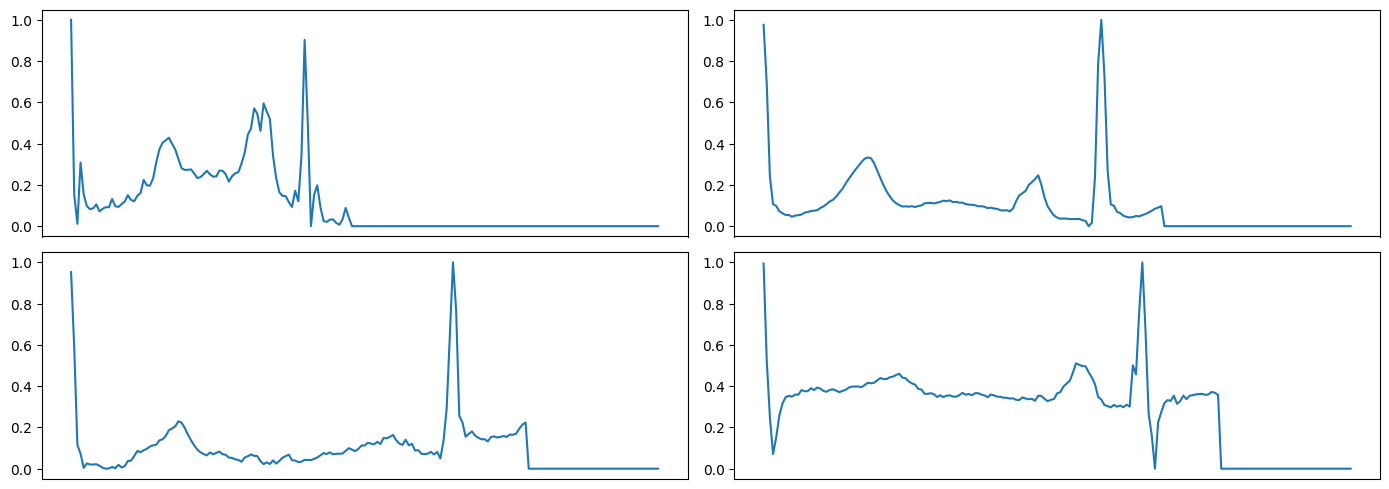

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

# Flatten the array for easy iteration
axs = axs.flatten()

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    axs[i].plot(X_train.iloc[i, :])
    
    # Set x ticks in 3 equidistant positions
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

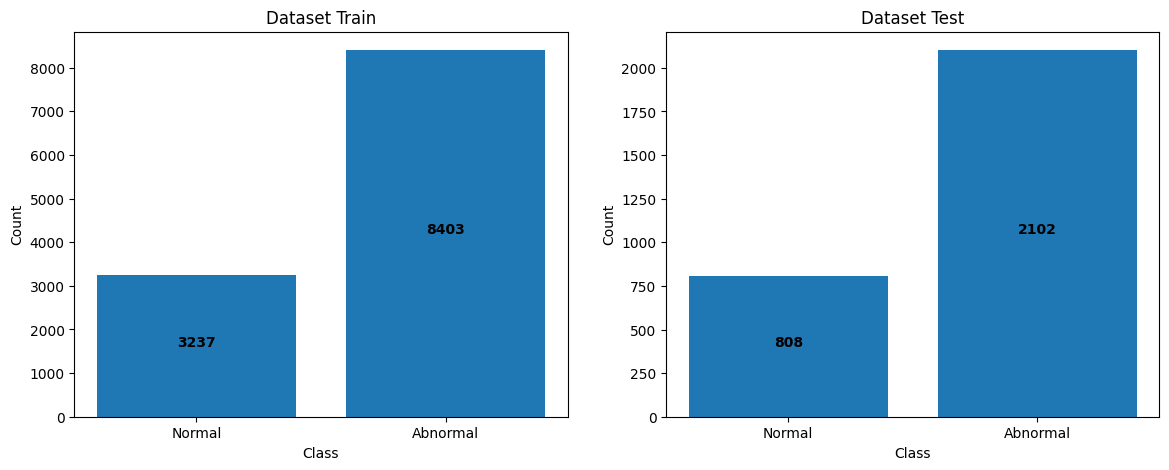

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(['Normal', 'Abnormal'], datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


In [126]:
n = len(y_train) + len(y_test)
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(len(datasets[i])/n*100) + '%')

Dataset Train: 80.0%
Dataset Test: 20.0%


## Classic Machine Learning Methods

### Logistic Regression

In [127]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Train accuracy: ' + str(log_reg.score(X_train, y_train)))
print('Test accuracy: ' + str(log_reg.score(X_test, y_test)))

Train accuracy: 0.8344501718213059
Test accuracy: 0.8223367697594501


### Random Forest

In [128]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Train accuracy: ' + str(rf.score(X_train, y_train)))
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9687285223367698


### Feature Design

In [129]:
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

X_train_extended['mean'] = X_train.mean(axis=1)
X_train_extended['std'] = X_train.std(axis=1)
X_train_extended['median'] = X_train.median(axis=1)
X_train_extended['max'] = X_train.max(axis=1)
X_train_extended['min'] = X_train.min(axis=1)
X_train_extended['range'] = X_train.max(axis=1) - X_train.min(axis=1)
X_train_extended['iqr'] = X_train.quantile(0.75, axis=1) - X_train.quantile(0.25, axis=1)
X_train_extended['q1'] = X_train.quantile(0.25, axis=1)
X_train_extended['q3'] = X_train.quantile(0.75, axis=1)
X_train_extended['kurtosis'] = X_train.kurtosis(axis=1)
X_train_extended['skew'] = X_train.skew(axis=1)
X_test_extended['mean'] = X_test.mean(axis=1)
X_test_extended['std'] = X_test.std(axis=1)
X_test_extended['median'] = X_test.median(axis=1)
X_test_extended['max'] = X_test.max(axis=1)
X_test_extended['min'] = X_test.min(axis=1)
X_test_extended['range'] = X_test.max(axis=1) - X_test.min(axis=1)
X_test_extended['iqr'] = X_test.quantile(0.75, axis=1) - X_test.quantile(0.25, axis=1)
X_test_extended['q1'] = X_test.quantile(0.25, axis=1)
X_test_extended['q3'] = X_test.quantile(0.75, axis=1)
X_test_extended['kurtosis'] = X_test.kurtosis(axis=1)
X_test_extended['skew'] = X_test.skew(axis=1)

In [130]:
log_reg_extended = LogisticRegression(max_iter=1000)
log_reg_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(log_reg_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(log_reg_extended.score(X_test_extended, y_test)))

Train accuracy: 0.8384020618556701
Test accuracy: 0.8340206185567011


In [131]:
rf_extended = RandomForestClassifier()
rf_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(rf_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(rf_extended.score(X_test_extended, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9707903780068728


## Recurrent Neural Networks - LSTM

In [204]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [228]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [229]:
input_size = 1  
hidden_size = 64
num_layers = 2
output_size = 1

In [230]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [231]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [232]:
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train_tensor.unsqueeze(2))
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.6993
Epoch [2/1000], Loss: 0.6943
Epoch [3/1000], Loss: 0.6894
Epoch [4/1000], Loss: 0.6847
Epoch [5/1000], Loss: 0.6800
Epoch [6/1000], Loss: 0.6753
Epoch [7/1000], Loss: 0.6705
Epoch [8/1000], Loss: 0.6655
Epoch [9/1000], Loss: 0.6603
Epoch [10/1000], Loss: 0.6548
Epoch [11/1000], Loss: 0.6488
Epoch [12/1000], Loss: 0.6424
Epoch [13/1000], Loss: 0.6353
Epoch [14/1000], Loss: 0.6276
Epoch [15/1000], Loss: 0.6190
Epoch [16/1000], Loss: 0.6099
Epoch [17/1000], Loss: 0.6006
Epoch [18/1000], Loss: 0.5931
Epoch [19/1000], Loss: 0.5919
Epoch [20/1000], Loss: 0.6003
Epoch [21/1000], Loss: 0.6038
Epoch [22/1000], Loss: 0.6009
Epoch [23/1000], Loss: 0.5962
Epoch [24/1000], Loss: 0.5928
Epoch [25/1000], Loss: 0.5913
Epoch [26/1000], Loss: 0.5913
Epoch [27/1000], Loss: 0.5920
Epoch [28/1000], Loss: 0.5928
Epoch [29/1000], Loss: 0.5936
Epoch [30/1000], Loss: 0.5940
Epoch [31/1000], Loss: 0.5942
Epoch [32/1000], Loss: 0.5940
Epoch [33/1000], Loss: 0.5937
Epoch [34/1000], Lo

In [233]:
with torch.no_grad():
    outputs = model(X_test_tensor.unsqueeze(2))
    loss = criterion(outputs, y_test_tensor.unsqueeze(1))
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor.unsqueeze(1)).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')

Accuracy: 0.7223, Loss: 0.5907



## Convolutional Neural Networks

## Attention and Transformers